<a href="https://colab.research.google.com/github/lenadub/Mini-Project-AI/blob/main/Final_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import libraries :**

In [ ]:
#library to get act upon files
import os
import shutil

#to upload file from local PC
from google.colab import files

# image library
from PIL import Image

# Pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Graphical libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import random




**Check we are running on top of a GPU :**

In [ ]:
if torch.cuda.is_available():
  print("GPU is available")
else:
  print("GPU is not available")

GPU is not available


**Install kaggle python module and fetch the dataset from kaggle :**

In [ ]:
!pip install kaggle

In [ ]:
# upload kaggle credential file
dir="/root/.kaggle"
cred_file = "kaggle.json"
cred_path=dir+"/"+ cred_file

if not os.path.exists(dir):
    os.makedirs(dir)
if not os.path.exists(cred_path):
  files.upload()
  shutil.move("/content/"+cred_file, dir)
  os.chmod(cred_path,0o600)


In [ ]:
# donwload dataset
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

5-flower-types-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzip the dataset into directory content
!unzip -o 5-flower-types-classification-dataset.zip -d /content/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/flower_images/Lilly/00048a5c76.jpg  
  inflating: /content/flower_images/Lilly/001ff6644e.jpg  
  inflating: /content/flower_images/Lilly/001ff6656j.jpg  
  inflating: /content/flower_images/Lilly/00973ad1b1.jpg  
  inflating: /content/flower_images/Lilly/00a7d512d6.jpg  
  inflating: /content/flower_images/Lilly/00f36a3c40.jpg  
  inflating: /content/flower_images/Lilly/013628cccc.jpg  
  inflating: /content/flower_images/Lilly/01998d6fb5.jpg  
  inflating: /content/flower_images/Lilly/01a0ec319c.jpg  
  inflating: /content/flower_images/Lilly/01b4bb0289.jpg  
  inflating: /content/flower_images/Lilly/025ef3ea44.jpg  
  inflating: /content/flower_images/Lilly/02a7a2df46.jpg  
  inflating: /content/flower_images/Lilly/02be2ca388.jpg  
  inflating: /content/flower_images/Lilly/035cce082f.jpg  
  inflating: /content/flower_images/Lilly/039eba79d4.jpg  
  inflating: /content/flower_images/L

In [ ]:
#directory containing the images
all_images = "/content/flower_images/"

Test affichage d'une fleur

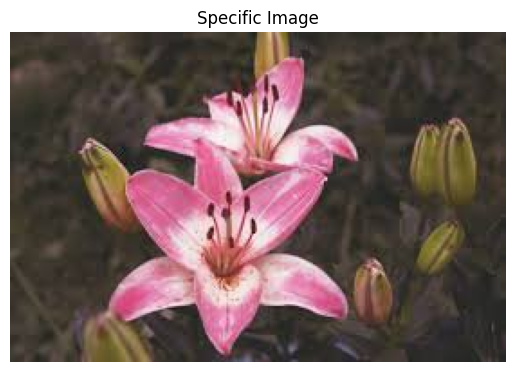

275 183


In [ ]:

# path to spezcific image
path_image = all_images+"Lilly/00048a5c76.jpg"

# load and display image
image = Image.open(path_image)
plt.imshow(image)
plt.axis('off')  # hide axes
plt.title("Specific Image")
plt.show()

width, height = image.size
print(width, height)



Qu. 1
Model Architecture:

Explain the following in this page:

1.	What model architecture have you selected
2.	Put a diagram of the architecture (Schematic)
3.	How many layers of the model have?
4.	How many hidden layers and neurons do you have?
5.	Have you changed the model architecture to improve performance.


Qu.2
Dataset Description:

Explain the following in this page:

1.	Details of the dataset (number of classes/ instances/ Images etc)
2.	What kind train / test split has been used
3.	What kind of data augmentation have been used


**Let's look into the contents of the dataset files**

There are 5 flower classes (lilly, lotus, orchid, sunflower, tulip) and there are 1000 instances in each class. The dataset is well balanced

In [ ]:
!ls /content/flower_images/

flowers = ["Lilly","Lotus","Orchid","Sunflower","Tulip"]

for flower in flowers :
  image_directory= all_images + flower
  list_images = [f for f in os.listdir(image_directory)]

  n_images = len(list_images)
  print(f"Total number of {flower} : {n_images}")

Lilly  Lotus  Orchid  Sunflower  Tulip
Total number of Lilly : 1000
Total number of Lotus : 1000
Total number of Orchid : 1000
Total number of Sunflower : 1000
Total number of Tulip : 1000


In [ ]:
for flower in flowers :
  image_directory = all_images + flower

  dimensions = []

  mean_width=0
  mean_height=0
  for image_file in os.listdir(image_directory):
    chemin_image = os.path.join(image_directory, image_file)
    image = Image.open(chemin_image)
    width, height = image.size
    dimensions.append((width, height))
    mean_width=mean_width+width
    mean_height=mean_height+height

  widths, heights = zip(*dimensions)
  mean_width = mean_width / len(widths)
  mean_height = mean_height / len(heights)
  print(f"{flower} mean dimensions : {mean_width} x {mean_height}")

Lilly mean dimensions : 526.447 x 455.695
Lotus mean dimensions : 525.325 x 422.159
Orchid mean dimensions : 489.962 x 403.079
Sunflower mean dimensions : 463.966 x 412.5
Tulip mean dimensions : 520.603 x 428.894


# Nouvelle section

**We will be using a CNN to classify the flowers.**

**In a first step, let's define the transformation we will apply to the images :**

In [ ]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),           # Resize images to 224x224 (commonly used size)
        transforms.RandomRotation(30),           # Data Augmentation by rotating images between 0 and 30 degrees
        transforms.RandomHorizontalFlip(p=0.5),  # Data Augmentation by horizontally flipping randomly 50% of the images
        transforms.RandomVerticalFlip(p=0.5),    # Data Augmentation by vertically flipping randomly 50% of the images
        transforms.ToTensor(),                   # Turn images into PyTorch tensors

        # # Normalize images to help the training (stable training, faster convergence, and better generalization)
        # Mean/std : hyperparameters
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]        # Commonly used nomrmlization mean and standard deviation values for image dataset
        #  mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),

    ])

**Let's load the images :**

In [ ]:
# Directory containing multiple subdirectories, each representing a class
data_directory = all_images

# Load images using ImageFolder, which will set the class label as the name of the directory (Lilly, Lotus, etc.) containing the images
dataset = ImageFolder(root=data_directory, transform=transform)
len(dataset) # whay 4999 samples rather than 5000 ??? To be further looked into when we have time

4999

In [ ]:
dataset.classes

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

**Let's display random transformed images :**

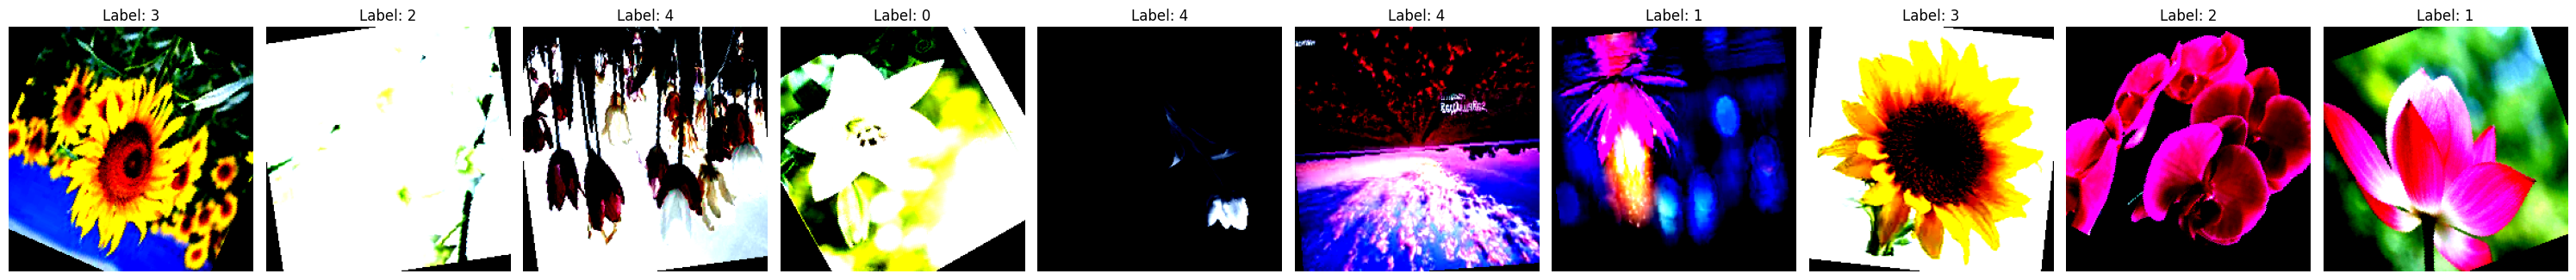

In [ ]:
# Display some resized images from the dataset
num_images_to_display = 10

# Generate 4 random indices between 0 and 999 (assuming 1000 images in the dataset)
random_indices = random.sample(range(len(dataset)), num_images_to_display)

# Create a figure and axes
fig, axes = plt.subplots(1, num_images_to_display, figsize=(30, 10))

# Display images and their labels
for i, idx in enumerate(random_indices):
    image, label = dataset[idx]  # Get image and label
    axes[i].imshow(image.permute(1, 2, 0))  # PyTorch tensors are (C, H, W), convert to (H, W, C) for display
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

**Let's split the dataset into training, validation and testing datasets**

The validation dataset is used to fine-tune the model during training, whereas the testing dataset is used at the very end to assess the model generalization capacity with unseen data.

In [ ]:
training_size = int(0.8 * len(dataset))
training_dataset, tmp_dataset = torch.utils.data.random_split(dataset,[training_size, len(dataset) - training_size])

validation_dataset_len = int(0.5*len(tmp_dataset))
testing_dataset_len = len(tmp_dataset) - validation_dataset_len
validation_dataset, testing_dataset  = torch.utils.data.random_split(tmp_dataset,[validation_dataset_len, testing_dataset_len])
len(training_dataset), len(validation_dataset),len(testing_dataset )

(3999, 500, 500)

**Let's initialise the three dataloaders. The training dataset will be shuffled for better generalization**

The mini-batch algorithm which submits multiple fix-sized batches in one learning epoch rather than the whole training set. Mini-batch training provides computational efficiency, faster convergence, regularization effects, better utilization of parallel hardware, and improved generalization.

In [ ]:
batch_size = 32 #hyperparameter
training_dataloader = DataLoader(training_dataset, batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size)
testing_dataloader = DataLoader(testing_dataset, batch_size)

**Let's define the architecture of the CNN as well as override some of the methodes of pytorch Neural Network or create additional ones**

In [ ]:
# compute accuracy
def accuracy(outputs, expected_labels):


    # Extract actual predicted label from NN outputs
    # ie the output node with highest value
    values, predicted_labels = torch.max(outputs, dim=1)

    # Sample-wise comparaison of the predicted labels with the actual labels.
    # Result (True or False) put in a tensor
    comp=(predicted_labels == expected_labels)

    # Then count the number of correct predictions using torch.sum()
    sum = torch.sum(comp)

    # Set DEBUG
    debug=0
    if debug:
      print(comp.view(-1))
      print(sum.view(-1))
      print(sum.item())
      print(torch.tensor(sum.item()/len(predicted_labels)).view(-1))

    # Convert the count to a integer with item
    # Divide the count by the total number of predictions to get a percentage
    # return the computed accuracy in a tensor
    return(torch.tensor(sum.item()/len(predicted_labels)))





class FlowerModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Architecture definition
        self.arch = nn.Sequential(

            # convolution & pool
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # convolution & pool
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # convolution
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Flattened Layer
            nn.Flatten(),

            # Fully conected Layer
            nn.Linear(200704, 128),
            nn.ReLU(),
            nn.Dropout(0.5),    # regularization technique recommended on many Internet sites
                                # half of the nodes are put to sleep randommly

            # Last classification layer
            nn.Linear(128, 5),
            #nn.Softmax(dim=1) # does not seems to work properly with pytorch cross_entropy. To be further looked into
            )


    # forward function
    def forward(self, x):
        return self.arch(x)


# Override training_step to force the bacth on the same XPU as the model
    def training_step(self, batch, idx, epoch):
         print(f'Training Batch index {idx} in epoch {epoch}')

         images, expected_labels=batch
         # Force dataset on available XPU (CPU/GPU)
         images = images.to(device)
         expected_labels = expected_labels.to(device)

         # Run prediction
         predicted_labels = self(images)

         # Calculate loss
         loss = torch.nn.functional.cross_entropy(predicted_labels, expected_labels)
         return loss


    # Override Validating_step to force the bacth on the same XPU as the model
    def validation_step(self, batch, idx):
        print(f'Validating Batch index {idx}')

        images, expected_labels = batch

        # Force dataset on available XPU (CPU/GPU)
        images = images.to(device)
        expected_labels = expected_labels.to(device)

        # Run Prediction
        predicted_labels = self(images)

        # Calculate loss
        loss = torch.nn.functional.cross_entropy(predicted_labels, expected_labels)

        # Calculate accuracy
        step_accuracy = accuracy(predicted_labels, expected_labels)
        return {'step validation loss': loss.detach(), 'step validation accuracy': step_accuracy}

    def validation_epoch(self, step_results):
        # compute mean of all validation step losses
        batch_losses = [res['step validation loss'] for res in step_results]
        epoch_loss = torch.stack(batch_losses).mean()

         # compute mean of all validation step accucaries
        batch_accs = [res['step validation accuracy'] for res in step_results]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'epoch validation loss': epoch_loss.item(), 'epoch validation accuracy': epoch_acc.item()}

    # create function to evaluate the model
    def evaluate(self, validation_loader):
        # Tells model that you are evaluating it.
        self.eval()

        step_results = [model.validation_step(batch,idx) for idx, batch in enumerate(validation_loader)]
        return model.validation_epoch(step_results)

 # create function to fit the model
    def fit(self,epochs, l_rate, training_loader, validation_loader, opt_func):

        # Keep an history of the perfs of the model
        history = []

        optimizer = opt_func(self.parameters(), l_rate)

        # Let us train over all the epochs
        for epoch in range(epochs):
          #
          # Training Phase for this epoch
          #
          # Tells model that you are training it.
          model.train()

          # Keep a record of the losses for all batches
          train_losses = []

          # Let us submit the batches
          for idx, batch in enumerate(training_loader):
              # Compute loss
              loss = self.training_step(batch,idx,epoch)
              # record batch loss
              train_losses.append(loss)

              # backprop and optimisation
              loss.backward()
              optimizer.step()

              # At end of mini-batch, zero-out the gradients before next step
              optimizer.zero_grad()

          #
          # Validation phase for this epoch againt the validation dataset
          # to regularly check how training goes as the number of epochs grows
          #
          result = self.evaluate(validation_loader)

          # Gather the losses over the epoch with torch.stack()
          # Take the mean (do not forget the first item to get a number rather than a tensor)
          result['epoch train loss'] = torch.stack(train_losses).mean().item()

          print("Epoch [{}], train loss: {:.4f}, val loss: {:.4f}, val acc: {:.4f}".format(epoch, result['epoch train loss'], result['epoch validation loss'], result['epoch validation accuracy']))

          # Keep record of the training perfs for the epoch
          history.append(result)

          # Set DEBUG
          debug = 0
          if debug :
               print(torch.stack(train_losses).view(-1))
               print(torch.stack(train_losses).mean().view(-1))

        return history

**Let's create the model**

In [ ]:
model = FlowerModel()
model

FlowerModel(
  (arch): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=200704, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [ ]:
#evaluate(model, validation_dataloader)

**Let us train the model**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs =   100               # Hyperparameter
optimization = torch.optim.Adam # Hyperparameter. After looking into it on the Internet, Adam is suppposedly the best optimizer for CNN. We will not change it
learning_rate = 0.001           # Hyperparameter to use if training is too slow, which is not our case with google colab GPU
                                # Let us choose a low value

# Let us trigger the training phase
# Performance of the training will be measured after each epoch againt the validation dataset
history = model.fit(num_epochs, learning_rate, training_dataloader, validation_dataloader, optimization)

Training Batch index 0 in epoch 0
Training Batch index 1 in epoch 0
Training Batch index 2 in epoch 0
Training Batch index 3 in epoch 0
Training Batch index 4 in epoch 0
Training Batch index 5 in epoch 0
Training Batch index 6 in epoch 0
Training Batch index 7 in epoch 0
Training Batch index 8 in epoch 0
Training Batch index 9 in epoch 0
Training Batch index 10 in epoch 0
Training Batch index 11 in epoch 0
Training Batch index 12 in epoch 0
Training Batch index 13 in epoch 0
Training Batch index 14 in epoch 0
Training Batch index 15 in epoch 0
Training Batch index 16 in epoch 0
Training Batch index 17 in epoch 0
Training Batch index 18 in epoch 0
Training Batch index 19 in epoch 0
Training Batch index 20 in epoch 0
Training Batch index 21 in epoch 0
Training Batch index 22 in epoch 0
Training Batch index 23 in epoch 0
Training Batch index 24 in epoch 0
Training Batch index 25 in epoch 0
Training Batch index 26 in epoch 0
Training Batch index 27 in epoch 0
Training Batch index 28 in epo

KeyboardInterrupt: ignored

**Let us check the accuracy**

In [ ]:

def plot_performance(history):

   # Gather perf values from the history list
    accuracies = [h['epoch validation accuracy'] for h in history]
    validation_losses = [h['epoch validation loss'] for h in history]
    training_losses = [h['train_loss'] for h in history]

    # plot them
    plt.plot(accuracies,color='green',label="Accuracy")
    plt.plot(validation_losses,color='red',label='Val_loss')
    plt.plot(training_losses,color='brown',label='Train_loss')
    plt.xlabel('epoch')
    plt.title('Perf vs. # of epochs');
    leg = plt.legend(loc='upper center')

plot_performance(history)

NameError: ignored

**Let us check wit the testing dataset :**

In [ ]:
model.evaluate(testing_dataloader)

Let us display the confusion matrix of the model against the testing dataset :

In [ ]:

def cnn_confustion_matrix(dataloader, dataset):
  nb_classes = len(list(dataset.classes))

  # create a zeroed tensor : nb_classes*nb_classes
  confusion_matrix = torch.zeros(nb_classes, nb_classes)

  with torch.no_grad()  :
    for idx, (images, labels) in enumerate(dataloader):

        # Force dataset on available XPU (CPU/GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Get predicted models from the model
        predicted_labels = model(images)

        # Compare with expected dataset

        #  the maximum value is taken for each row of the predicted_labels tensor,
        #  ie the predicted labels for each sample of the batch
        # These predicted lables are put in tensor preds
        _, preds = torch.max(predicted_labels, dim=1)

        # Method torch.view with arg -1  is used to flatten these tensors to one dimension tensor
        # Then we iterate the 1-dim tensor to get and compare the expected labels and the predicted labels for each sample

        for expected, predicted in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[expected.long(), predicted.long()] += 1   # The long() function turns the elements of 1 dim tensors expected and predicted to long int for indexing the confusion_matrix.

        # DEBUG
        #print(labels.view(-1))
        #print(preds.view(-1))
        #print(expected.long())
        #print(predicted.long())




  plt.figure(figsize=(15,10))

  classes = list(dataset.classes)
  dataframe = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
  heatmap = sns.heatmap(dataframe, annot=True, fmt="d")

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=17)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=17)
  plt.ylabel('Expected label')
  plt.xlabel('Predicted label')

print(cnn_confustion_matrix(testing_dataloader, dataset))

In [ ]:
torch.save(model.state_dict(), "/content/save_model_simple_epoch_100")